In [62]:
!pip install optuna

In [63]:
# === 📦 Core Libraries ===
import pandas as pd
import numpy as np
import math
import pickle
import datetime

# === 📊 Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === 🧼 Data Preprocessing ===
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline

# === 📐 Statistical Tools ===
from scipy import stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === 🤖 Machine Learning Models ===
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import lightgbm as lgb

# === 📈 Model Evaluation ===
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# === 🛠️ Optimization & Utilities ===
import optuna
from sklearn.model_selection import train_test_split

# === 💵 Financial & External Data ===
import pandas_datareader.data as web

# === 🔍 Model Explainability ===
import shap


In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import os
os.listdir('/content/drive/My Drive/')

['StanCode 201 GAN來苦盡-NVDIA的態勢分析.zip',
 'Untitled spreadsheet.gsheet',
 'Colab Notebooks',
 'nasdaq100_10k.db',
 'SC201_poster_macro_percentchange.csv',
 'cluster_labels.csv',
 'historical_data.csv',
 'FinScope3D',
 '2025_AI_GO',
 'final_model.pkl']

#### Load data

In [97]:
#load file
TRAIN_FILE = '/content/drive/My Drive/SC201_poster_macro_percentchange.csv'
#load data using pandas
df = pd.read_csv(TRAIN_FILE)
df.shape

(1515, 27)

## Data Preparation
1. check the data
2. Remove rows where the missing ratio in financial report variables exceeds 50%
3. check missing values
4. explore data using heatmap & boxplot (correlation & distribution)

In [98]:
df.shape
df.head() #check first five rows
#check columns name
df.columns

Index(['ID', 'year', 'Y', 'return_on_stock', 'NDX_annual_return',
       'Price to Book Ratio', 'Profit Margins', 'Enterprise to Revenue',
       'Market Cap', 'earningsGrowth', 'Revenue Growth', 'Return on Assets',
       'Trailing EPS', 'Return on Equity', 'Current Ratio', 'trailingPE',
       'Price to Sales Ratio', 'operating margin', 'DGS10', 'PCEPILFE',
       'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE', 'FEDFUNDS',
       'USEPUINDXD'],
      dtype='object')

In [99]:
#drop the data where return_on_stock == 0 & year = 2024
df = df[df['return_on_stock'] != 0]
df = df[df['year'] != 2024]

In [100]:
# Remove rows where the missing ratio in financial report variables exceeds 50%
financial_columns = ['Price to Book Ratio', 'Profit Margins', 'Enterprise to Revenue', 'Market Cap',
                  'Revenue Growth', 'earningsGrowth', 'trailingPE', 'Return on Assets', 'Return on Equity', 'Current Ratio', 'Trailing EPS', 'operating margin', 'Price to Sales Ratio']

# Calculate the missing ratio for these columns
missing_ratio = df[financial_columns].isna().mean(axis=1)

# Identify rows where the missing ratio exceeds 50%
threshold = 0.5  # 50%
df = df[missing_ratio <= threshold]

In [101]:
#check missing values
missing_values_df = df.isna().sum()
print(missing_values_df)

ID                         0
year                       0
Y                          0
return_on_stock            0
NDX_annual_return          0
Price to Book Ratio       34
Profit Margins             1
Enterprise to Revenue      3
Market Cap                 2
earningsGrowth           105
Revenue Growth             5
Return on Assets           4
Trailing EPS              24
Return on Equity          99
Current Ratio             43
trailingPE               148
Price to Sales Ratio      69
operating margin           1
DGS10                      0
PCEPILFE                   0
INDPRO                     0
RBUSBIS                    0
M2SL                       0
GDP_Growth_Rate            0
UNRATE                     0
FEDFUNDS                   0
USEPUINDXD                 0
dtype: int64


In [102]:
# Train
print('--- Train ---\n')
print(100*df.isnull().sum() / df.shape[0])
print('\n')

--- Train ---

ID                        0.000000
year                      0.000000
Y                         0.000000
return_on_stock           0.000000
NDX_annual_return         0.000000
Price to Book Ratio       2.739726
Profit Margins            0.080580
Enterprise to Revenue     0.241741
Market Cap                0.161160
earningsGrowth            8.460919
Revenue Growth            0.402901
Return on Assets          0.322321
Trailing EPS              1.933924
Return on Equity          7.977438
Current Ratio             3.464948
trailingPE               11.925866
Price to Sales Ratio      5.560032
operating margin          0.080580
DGS10                     0.000000
PCEPILFE                  0.000000
INDPRO                    0.000000
RBUSBIS                   0.000000
M2SL                      0.000000
GDP_Growth_Rate           0.000000
UNRATE                    0.000000
FEDFUNDS                  0.000000
USEPUINDXD                0.000000
dtype: float64




In [103]:
#using heat map to visualize feature correlation

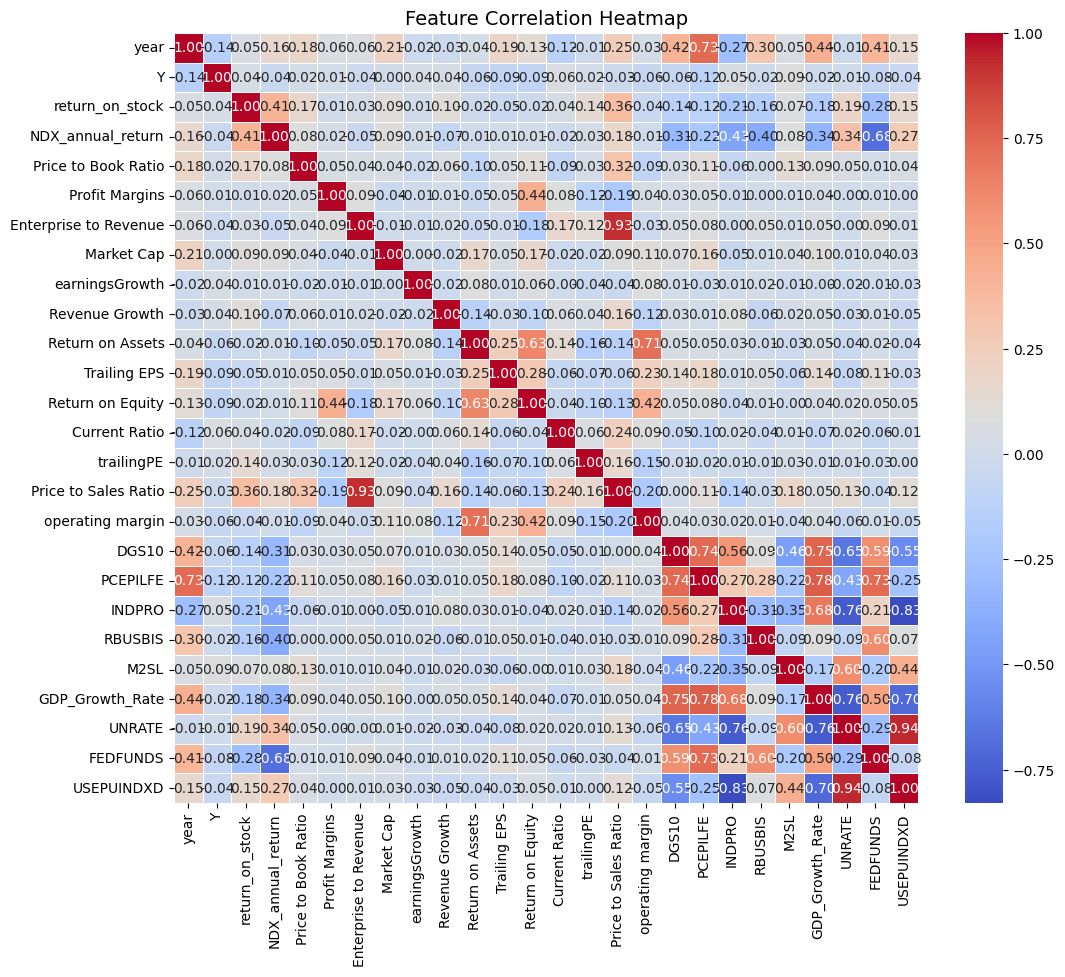

In [104]:
# Extract numerical features from df
numeric_df = df.select_dtypes(include=[np.number])

# Set figure size
plt.figure(figsize=(12, 10))

# Plot the correlation matrix heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Display the heatmap
plt.show()

In [105]:
#visualize the distribution of financial data

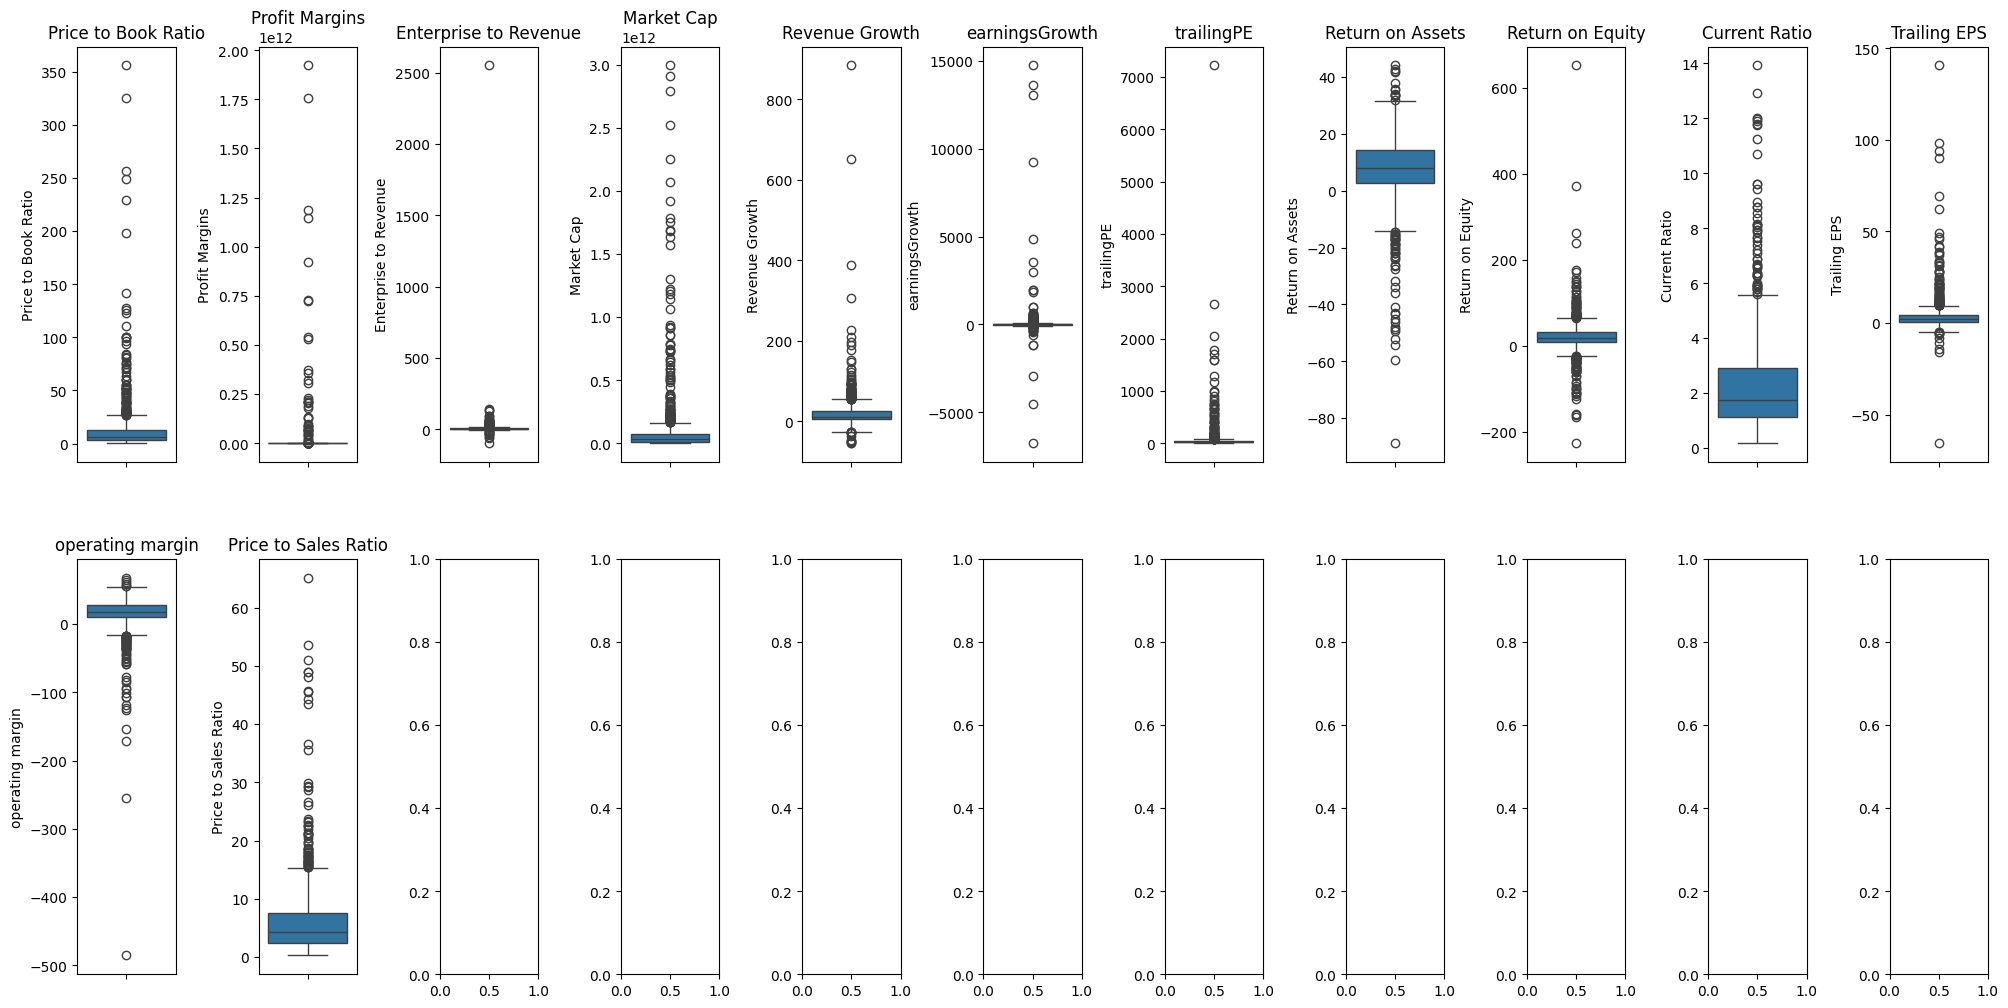

In [106]:
# Extract numerical features from df
numeric_df = df[financial_columns]

# Calculate the number of subplots needed
num_cols = len(numeric_df.columns)  # Number of features
num_cols_per_row = 11  # Maximum number of plots per row
num_rows = math.ceil(num_cols / num_cols_per_row)  # Calculate total rows needed

# Create subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 10))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot boxplots for each feature
for index, col in enumerate(numeric_df.columns):
    sns.boxplot(y=numeric_df[col], data=numeric_df, ax=axs[index])
    axs[index].set_title(col)  # Add feature name as title

# Adjust layout to prevent overlapping titles
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# Display the plots
plt.show()

In [107]:
# find the distribution of features

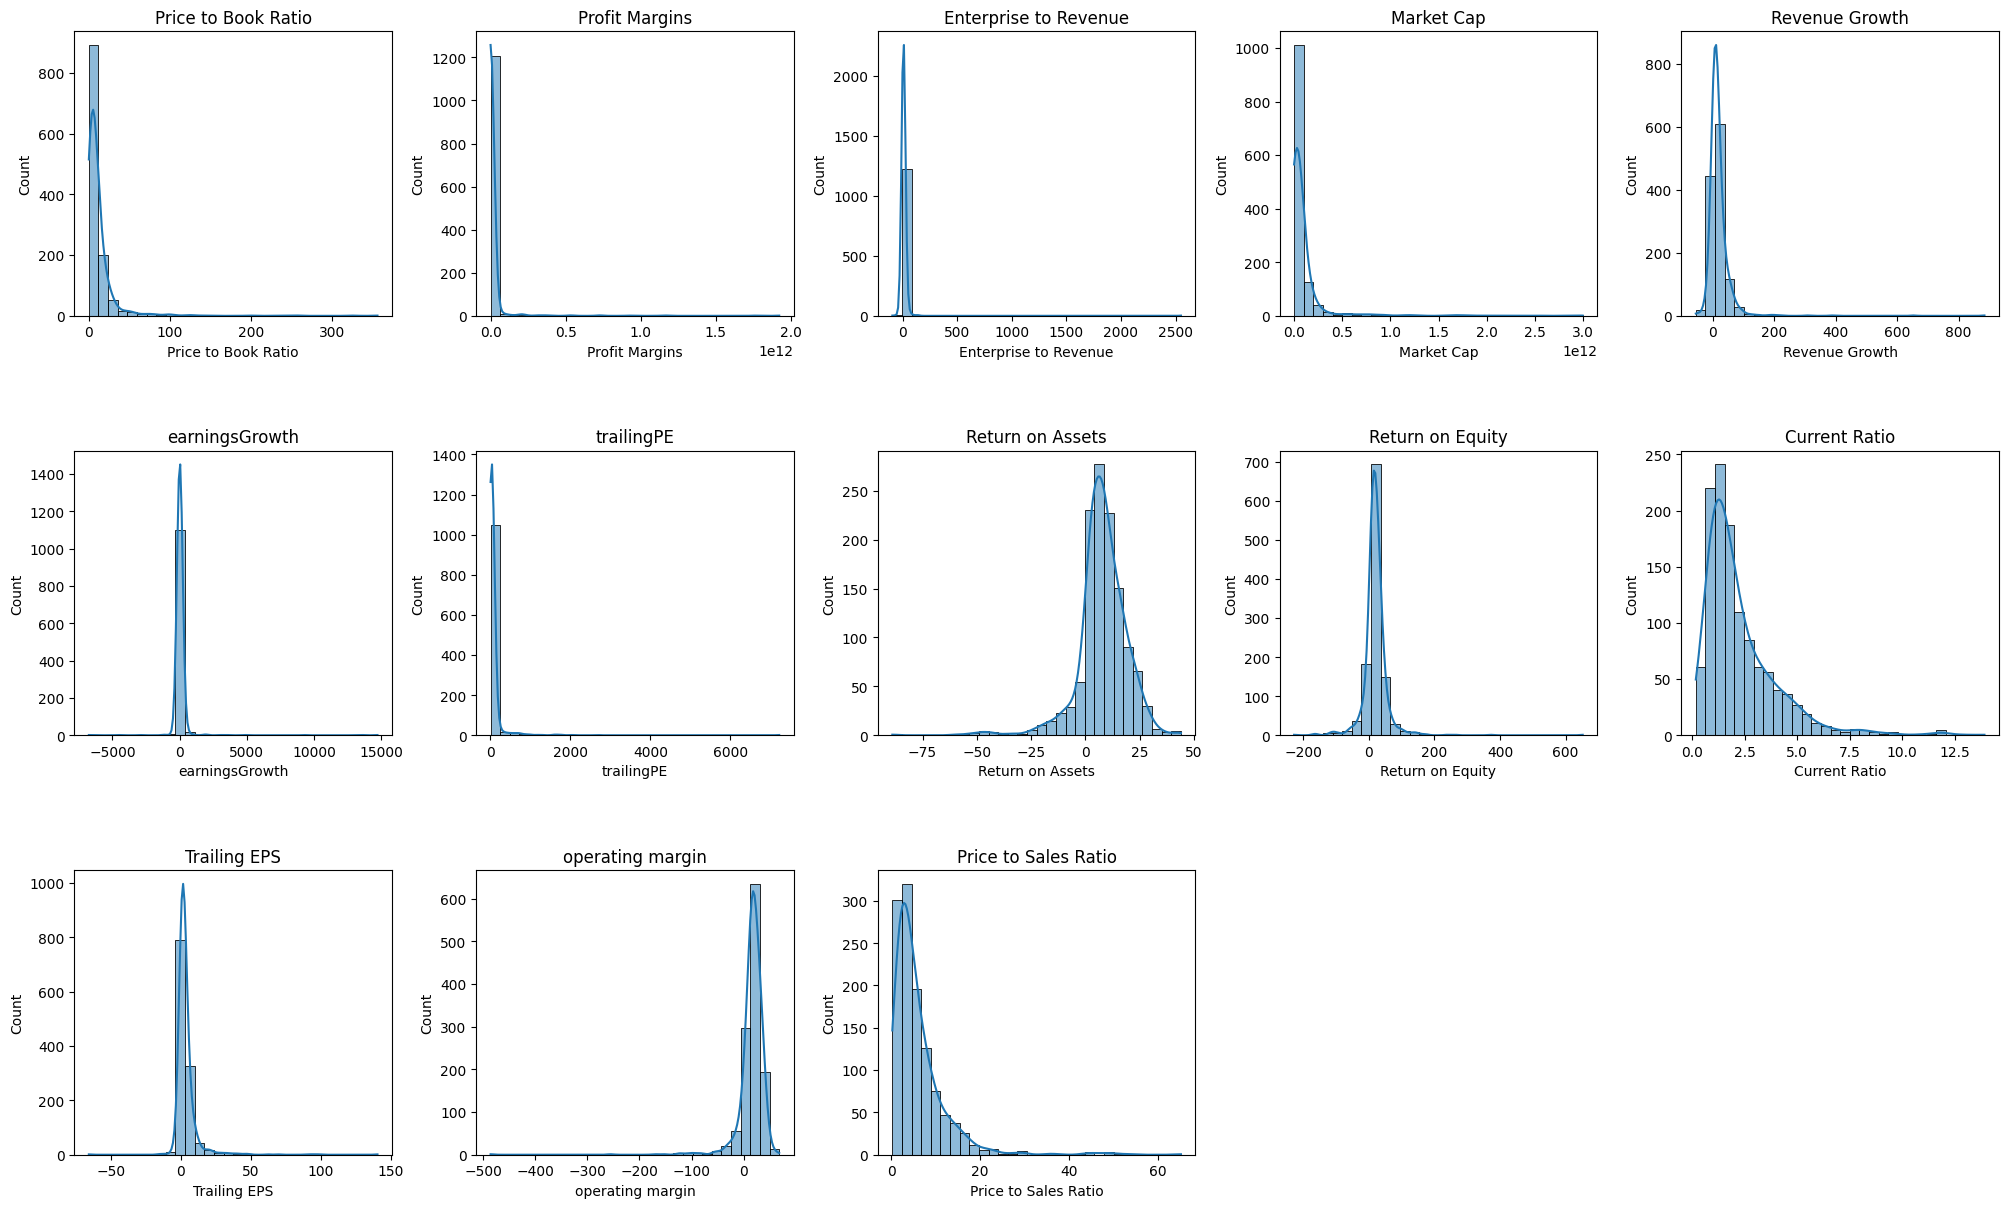

In [108]:
# Calculate the number of subplots needed
num_cols = len(numeric_df.columns)  # Number of features
num_cols_per_row = 5  # Maximum number of plots per row (reduced for better readability)
num_rows = math.ceil(num_cols / num_cols_per_row)  # Calculate total rows needed

# Create subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(20, num_rows * 4))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Plot distributions for each feature
for index, col in enumerate(numeric_df.columns):
    sns.histplot(numeric_df[col], kde=True, bins=30, ax=axs[index])  # Histogram + KDE
    axs[index].set_title(col)  # Add feature name as title

# Remove empty subplots if any
for i in range(index + 1, len(axs)):
    fig.delaxes(axs[i])

# Adjust layout to prevent overlapping titles
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# Display the plots
plt.show()

In [109]:
df = df.drop(columns=['Price to Sales Ratio', 'trailingPE'])

## Data Cleaning
1. completing mssing values use KNN
2. minmax
3. Use PCA to identify the most suitable clustering method (k-means or DBSCAN) for companies .
4. clustering k-means

In [110]:
def knn_impute_dataframe(df, id_column='ID', n_neighbors=5):
    """
    Apply KNN imputation to fill missing values for numeric columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        id_column (str): The column to exclude from imputation (e.g., 'ID').
        n_neighbors (int): Number of neighbors for KNN imputation.

    Returns:
        pd.DataFrame: Imputed dataframe with the ID column preserved.
    """
    print("🔍 Missing Values Before Imputation:")
    print(df.isna().sum())

    # Separate ID and numeric data
    ids = df[id_column]
    df_numeric = df.drop(columns=[id_column])

    # KNN Imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_filled_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

    # Combine back with ID
    df_filled = pd.concat([ids.reset_index(drop=True), df_filled_numeric], axis=1)

    print("\n✅ Missing Values After Imputation:")
    print(df_filled.isna().sum())

    return df_filled


In [111]:
df = knn_impute_dataframe(df)

🔍 Missing Values Before Imputation:
ID                         0
year                       0
Y                          0
return_on_stock            0
NDX_annual_return          0
Price to Book Ratio       34
Profit Margins             1
Enterprise to Revenue      3
Market Cap                 2
earningsGrowth           105
Revenue Growth             5
Return on Assets           4
Trailing EPS              24
Return on Equity          99
Current Ratio             43
operating margin           1
DGS10                      0
PCEPILFE                   0
INDPRO                     0
RBUSBIS                    0
M2SL                       0
GDP_Growth_Rate            0
UNRATE                     0
FEDFUNDS                   0
USEPUINDXD                 0
dtype: int64

✅ Missing Values After Imputation:
ID                       0
year                     0
Y                        0
return_on_stock          0
NDX_annual_return        0
Price to Book Ratio      0
Profit Margins           0
E

In [112]:
# Reshape panel data to wide format
def reshape_panel_data(df):
    """
    Pivot the panel data to wide format (one row per company).
    """
    df_pivot = df.pivot(index="ID", columns="year")
    df_pivot.columns = [f"{col[0]}_{col[1]}" for col in df_pivot.columns]
    df_pivot.reset_index(inplace=True)
    return df_pivot

# Scale and impute missing values
def scale_and_impute_data(df_pivot):
    """
    Scale the data using MinMaxScaler and fill missing values with 0.
    """
    numeric_cols = df_pivot.select_dtypes(include=[np.number]).columns
    data = df_pivot[numeric_cols]

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    data_scaled = np.nan_to_num(data_scaled, nan=0.0)

    df_pivot[numeric_cols] = data_scaled
    print("✅ Scaling & Imputation completed!")
    return df_pivot

# Plot PCA 2D projection
def plot_pca_projection(data):
    """
    Perform PCA and plot 2D projection.
    """
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA 2D Projection of Financial Data")
    plt.show()

# Elbow Method to find optimal K
def find_optimal_k(data, k_range=range(2, 9)):
    """
    Use the Elbow Method to determine optimal number of clusters.
    """
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow Method to Find Optimal K")
    plt.show()

# Run KMeans and add cluster labels
def run_kmeans(df_pivot, best_k=5):
    """
    Apply K-Means clustering and append cluster labels.
    """
    numeric_cols = df_pivot.select_dtypes(include=[np.number]).columns
    data = df_pivot[numeric_cols]

    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    df_pivot["Cluster"] = kmeans.fit_predict(data)

    # PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_pivot["Cluster"], palette="tab10", alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"K-Means Clustering (K={best_k})")
    plt.legend(title="Cluster")
    plt.show()

    return df_pivot

# Merge cluster labels back to original panel dataframe
def merge_clusters_to_original(df_original, df_pivot):
    """
    Merge cluster labels into the original panel dataframe.
    """
    df_clusters = df_pivot[["ID", "Cluster"]]
    df_merged = df_original.merge(df_clusters, on="ID", how="left")
    df_encoded = pd.get_dummies(df_merged, columns=["Cluster"], prefix="Cluster", dtype=int)
    df_clusters.to_csv("cluster_labels.csv", index=False)
    print("✅ Clustering results merged and saved.")
    return df_encoded


✅ Scaling & Imputation completed!


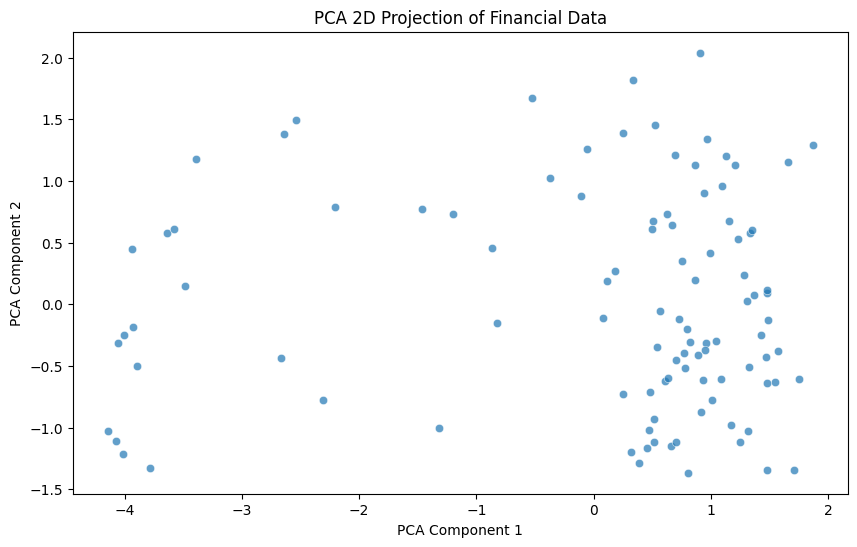

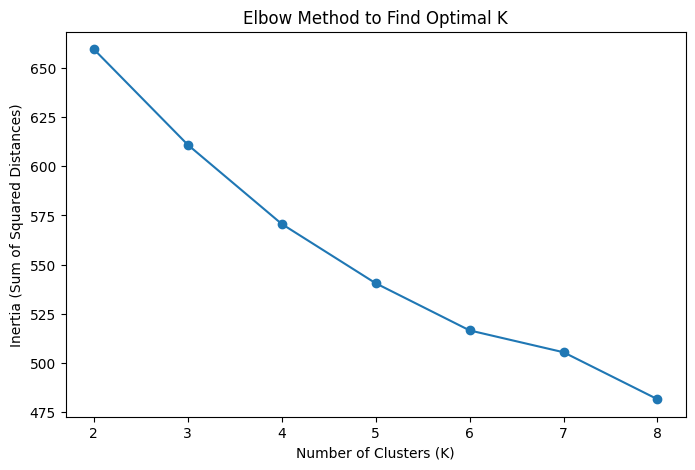

<ipython-input-112-8b985ccb8656>:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivot["Cluster"] = kmeans.fit_predict(data)


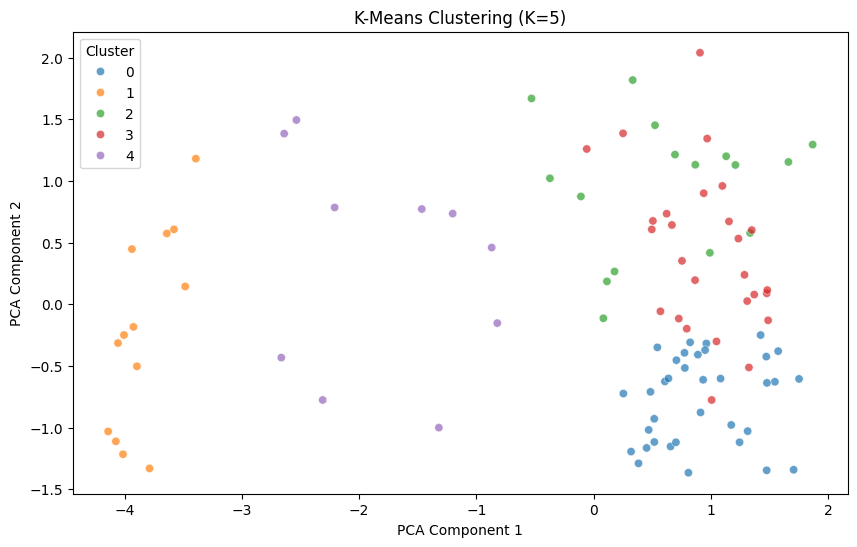

✅ Clustering results merged and saved.


In [113]:
df_pivot = reshape_panel_data(df)
df_pivot = scale_and_impute_data(df_pivot)
plot_pca_projection(df_pivot.select_dtypes(include=[np.number]))
find_optimal_k(df_pivot.select_dtypes(include=[np.number]))
df_pivot = run_kmeans(df_pivot, best_k=5)
df = merge_clusters_to_original(df, df_pivot)

Use PCA to identify the most suitable clustering method (k-means or DBSCAN) for companies .

### 🧪 Step : Feature Engineering

In this step, we enhance the dataset by adding **engineered features** that capture interaction effects, ratios, and market-relative signals. These new features aim to help the model better differentiate between companies that are likely to outperform the market.

#### 🔹 Z-score Normalization
We calculate 3-year rolling **Z-scores** (standardized scores) for two key valuation metrics:
- **Profit Margins** (`Profit_Margin_Zscore_Market`)
- **Price to Book Ratio** (`PB_Zscore_Market`)

Z-scores help normalize company values relative to the market average in each year, highlighting how "unusual" or "outperforming" a company is in a given context.

#### 🔹 Ratio Features
We create features that combine financial and macroeconomic variables to capture complex economic signals:
- `ROE_Growth`: Product of Return on Equity and Revenue Growth
- `MarketCap_EPS`: Market Capitalization × Trailing EPS
- `PB_ROE`: Price-to-Book Z-score × Return on Equity
- `FedFunds_MCap`: Federal Funds Rate × Market Capitalization
- `EPS_per_MarketCap`: EPS scaled by Market Cap (profit per dollar invested)
- `Revenue_UNRATE_ratio`: Revenue Growth relative to Unemployment Rate

These features introduce economic structure into the model and may help improve generalization to out-of-sample periods.


In [114]:
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add engineered features to the input DataFrame for stock outperformance prediction.

    This function performs:
    - Z-score normalization for Profit Margins and Price-to-Book Ratio
    - Creation of several interaction and ratio-based features

    Parameters:
        df (pd.DataFrame): Input DataFrame containing financial and macroeconomic features.

    Returns:
        pd.DataFrame: DataFrame with new engineered features added.
    """
    df = df.copy()

    # === 📏 Z-score features based on rolling 3-year stats (by year) ===

    # Z-score of Profit Margins
    profit_margin_mean = df.groupby("year")["Profit Margins"].transform(lambda x: x.rolling(3, min_periods=1).mean())
    profit_margin_std = df.groupby("year")["Profit Margins"].transform(lambda x: x.rolling(3, min_periods=1).std())
    profit_margin_std = profit_margin_std.replace(0, np.nan)
    df["Profit_Margin_Zscore_Market"] = (df["Profit Margins"] - profit_margin_mean) / profit_margin_std
    df["Profit_Margin_Zscore_Market"].fillna(0, inplace=True)

    # Z-score of Price-to-Book Ratio
    pb_mean = df.groupby("year")["Price to Book Ratio"].transform(lambda x: x.rolling(3, min_periods=1).mean())
    pb_std = df.groupby("year")["Price to Book Ratio"].transform(lambda x: x.rolling(3, min_periods=1).std())
    pb_std = pb_std.replace(0, np.nan)
    df["PB_Zscore_Market"] = (df["Price to Book Ratio"] - pb_mean) / pb_std
    df["PB_Zscore_Market"].fillna(0, inplace=True)

    # === 🧠 ratio-based features ===

    # df['ROE_Growth'] = df['Return on Equity'] * df['Revenue Growth']
    # #df['MarketCap_EPS'] = df['Market Cap'] * df['Trailing EPS']
    # #df['PB_ROE'] = df['PB_Zscore_Market'] * df['Return on Equity']
    # df['FedFunds_MCap'] = df['FEDFUNDS'] * df['Market Cap']
    # df['EPS_per_MarketCap'] = df['Trailing EPS'] / (df['Market Cap'] + 1e-6)
    # df['Revenue_UNRATE_ratio'] = df['Revenue Growth'] / (df['UNRATE'] + 1e-6)

    return df


In [115]:
df = add_engineered_features(df)

<ipython-input-114-a72e52abbde2>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Profit_Margin_Zscore_Market"].fillna(0, inplace=True)
<ipython-input-114-a72e52abbde2>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [116]:
df.to_csv("historical_data.csv", index=False)

In [117]:
# # drop 'Id', 'earningsgrowth'
df=df.drop(columns=['ID', 'earningsGrowth'])
#df=df.drop(columns=['ID', 'earningsGrowth', "Profit Margins", "Price to Book Ratio"])

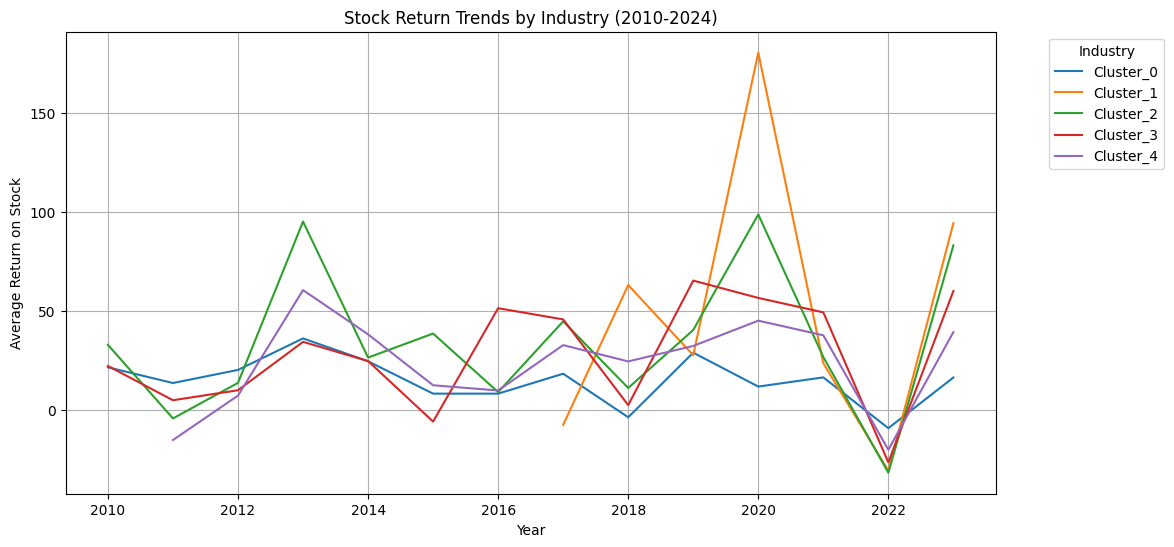

In [118]:
# Analyze stock return performance across different industries over the years

# Ensure 'year' is in numerical format
df['year'] = df['year'].astype(int)

# Select all industry-related columns that start with 'Cluster'
industry_columns = [col for col in df.columns if col.startswith('Cluster')]

# Plot line chart for industry stock returns
plt.figure(figsize=(12, 6))

# Plot a line for each industry
for industry in industry_columns:
    industry_mean_return = df[df[industry] == 1].groupby('year')['return_on_stock'].mean()
    plt.plot(industry_mean_return.index, industry_mean_return.values, label=industry)

# Set chart title and labels
plt.title("Stock Return Trends by Industry (2010-2024)")
plt.xlabel("Year")
plt.ylabel("Average Return on Stock")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Display the plot
plt.show()


In [119]:
# Apply sine & cosine transformation to 'year'
# The time period is 14 years (2010 to 2023)

period = 14

# Compute sine and cosine transformations
df['year_sin'] = np.sin(2 * np.pi * df['year'] / period)
df['year_cos'] = np.cos(2 * np.pi * df['year'] / period)



```
# This is formatted as code
```


---

## 🔍 Variance Inflation Factor (VIF)

To ensure our model isn't negatively affected by **multicollinearity**, we calculate the **Variance Inflation Factor (VIF)** for each feature.

- **VIF** measures how strongly a feature is correlated with other features.
- **VIF > 10** is commonly considered high and may indicate redundancy.

We use this step to:
- Improve model stability and interpretability.
- Avoid overfitting caused by highly correlated inputs.

This process helps us select cleaner, more independent features before training models like logistic regression.

---



In [120]:
# def calculate_vif(X):


#     # Add a constant column to the dataset (intercept term for regression)
#     X_const = add_constant(X)

#     vif_data = []

#     # Loop through each feature to calculate its VIF
#     for i in range(X_const.shape[1]):
#         try:
#             # Compute the VIF for feature i
#             vif = variance_inflation_factor(X_const.values, i)
#         except:
#             # If VIF calculation fails (e.g., due to perfect collinearity), set to NaN
#             vif = np.nan
#         # Store the feature name and its corresponding VIF value
#         vif_data.append((X_const.columns[i], vif))

#     # Return results as a DataFrame
#     return pd.DataFrame(vif_data, columns=["feature", "VIF"])


In [121]:
# vif_result = calculate_vif(df)
# print(vif_result)

 Add PCA Features from Macroeconomic Variables

In [122]:
# def apply_macro_pca(df, macro_cols, n_components=2,
#                     pca_path="pca_macro.pkl", scaler_path="scaler_macro.pkl"):
#     """
#     Apply PCA to macroeconomic features, merge the result with panel data,
#     and save the PCA and scaler models.

#     Parameters:
#         df (pd.DataFrame): Panel data with macro and firm-level features, including 'year'.
#         macro_cols (list): Column names of macroeconomic variables.
#         n_components (int): Number of principal components to keep (default is 2).
#         pca_path (str): Path to save the PCA model.
#         scaler_path (str): Path to save the scaler model.

#     Returns:
#         pd.DataFrame: DataFrame with added principal components (e.g., macro_PC1, macro_PC2).
#     """
#     macro_yearly = df[['year'] + macro_cols].drop_duplicates('year').sort_values('year')
#     scaler = StandardScaler()
#     macro_scaled = scaler.fit_transform(macro_yearly[macro_cols])

#     pca = PCA(n_components=n_components)
#     macro_pca = pca.fit_transform(macro_scaled)

#     pca_cols = [f'macro_PC{i+1}' for i in range(n_components)]
#     df_macro_pca = pd.DataFrame(macro_pca, columns=pca_cols)
#     df_macro_pca['year'] = macro_yearly['year'].values

#     df_with_pca = df.merge(df_macro_pca, on='year', how='left')

#     with open(pca_path, "wb") as f:
#         pickle.dump(pca, f)
#     with open(scaler_path, "wb") as f:
#         pickle.dump(scaler, f)

#     print(f"PCA completed. Added columns: {pca_cols}")
#     print(f"Models saved to: {pca_path}, {scaler_path}")
#     return df_with_pca


In [123]:
# macro_cols = ['DGS10', 'PCEPILFE', 'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE', 'FEDFUNDS', 'USEPUINDXD']

# df = apply_macro_pca(df, macro_cols, n_components=2)


In [124]:
# df["covid_period"] = (df["year"] >= 2020) & (df["year"] <= 2022)
# df["covid_period"] = df["covid_period"].astype(int)

In [125]:
X = df.drop(columns=['year', 'Y'])
features = X.columns.tolist()
print(features)

['return_on_stock', 'NDX_annual_return', 'Price to Book Ratio', 'Profit Margins', 'Enterprise to Revenue', 'Market Cap', 'Revenue Growth', 'Return on Assets', 'Trailing EPS', 'Return on Equity', 'Current Ratio', 'operating margin', 'DGS10', 'PCEPILFE', 'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE', 'FEDFUNDS', 'USEPUINDXD', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Profit_Margin_Zscore_Market', 'PB_Zscore_Market', 'year_sin', 'year_cos']


## Model deployment & Evaluation

### LightGBM

### baseline logistic regression

In [126]:
train_df = df[df['year'] <= 2021]
test_df = df[df['year'] >= 2022]

X_train = train_df.drop(columns=["Y", 'year'])
y_train = train_df['Y']

X_val = test_df.drop(columns=["Y", 'year'])
y_val = test_df['Y']


In [127]:
X_train.columns

Index(['return_on_stock', 'NDX_annual_return', 'Price to Book Ratio',
       'Profit Margins', 'Enterprise to Revenue', 'Market Cap',
       'Revenue Growth', 'Return on Assets', 'Trailing EPS',
       'Return on Equity', 'Current Ratio', 'operating margin', 'DGS10',
       'PCEPILFE', 'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE',
       'FEDFUNDS', 'USEPUINDXD', 'Cluster_0', 'Cluster_1', 'Cluster_2',
       'Cluster_3', 'Cluster_4', 'Profit_Margin_Zscore_Market',
       'PB_Zscore_Market', 'year_sin', 'year_cos'],
      dtype='object')

In [128]:
# === Baseline Logistic Regression ===

def baseline_logistic(X_train, y_train, X_val, y_val):
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]
    print("[Baseline] F1:", f1_score(y_val, y_pred))
    print("[Baseline] AUC:", roc_auc_score(y_val, y_prob))

In [ ]:
# === 📆 Stock Outperformance Prediction Pipeline ===
# Panel data: 100 companies x 15 years (2010–2024)
# Target: Whether a stock outperforms the market (NDX) with +2% threshold

# === 🔁 Expanding Window CV (train until 2021) ===
def expanding_year_split(df, start_year=2010, end_year=2021):
    unique_years = sorted(df['year'].unique())
    for i in range(len(unique_years)):
        train_years = unique_years[:i+1]
        if max(train_years) >= end_year:
            break
        val_year = unique_years[i+1]
        if val_year > end_year:
            break
        train_idx = df[df['year'].isin(train_years)].index.to_numpy()
        val_idx = df[df['year'] == val_year].index.to_numpy()
        yield train_idx, val_idx

# === 🔍 LightGBM + Optuna Tuning ===
def tune_lightgbm_with_optuna(df, features, n_trials=50):
    def objective(trial):
        params = {
            "objective": "binary",
            "metric": "auc",
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "num_leaves": trial.suggest_int("num_leaves", 15, 50),
            "max_depth": trial.suggest_int("max_depth", 3, 6),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "scale_pos_weight": 2.19,  # ⚖️ Adjust for class imbalance
            "verbosity": -1,
        }
        aucs = []
        for train_idx, val_idx in expanding_year_split(df, start_year=2010, end_year=2021):
            X_train, X_val = df.loc[train_idx, features], df.loc[val_idx, features]
            y_train, y_val = df.loc[train_idx, 'Y'], df.loc[val_idx, 'Y']
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train)
            y_prob = model.predict_proba(X_val)[:, 1]
            aucs.append(roc_auc_score(y_val, y_prob))
        return np.mean(aucs)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    print("Best Parameters:", study.best_params)
    return study.best_params

# === 🌳 Final Training & Prediction (2022–2023) ===
def predict_2022_2023(df, features, best_params):
    df_train = df[df['year'] <= 2021]
    df_test = df[df['year'].isin([2022, 2023])]

    X_train, y_train = df_train[features], df_train['Y']
    X_test, y_test = df_test[features], df_test['Y']

    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📅 2022–2023 Prediction → AUC: {auc:.4f}, F1: {f1:.4f}")
    return model, auc, f1

# === 🧠 Feature Selection (LGB Importance) ===
def select_top_features_lgb(model, X, top_n=10):
    importances = model.feature_importances_
    top_idx = np.argsort(importances)[-top_n:][::-1]
    return X.iloc[:, top_idx]

# === 📊 Compare Full vs Top-N Feature Model (LGB Importance) ===
# def compare_models_lgb_importance(df, features, best_params, top_n=20):
#     print("\n=== Full Feature Model ===")
#     model_full, auc_full, f1_full = predict_2022_2023(df, features, best_params)

#     df_test = df[df['year'].isin([2022, 2023])]
#     y_true_full = df_test['Y']
#     y_pred_full = model_full.predict(df_test[features])

#     print("\n=== Top Feature Model (LGB Importance) ===")
#     X_all = df[features]
#     X_top = select_top_features_lgb(model_full, X_all, top_n=top_n)
#     df_top = df[X_top.columns.tolist() + ['Y', 'year']]
#     model_top, auc_top, f1_top = predict_2022_2023(df_top, X_top.columns.tolist(), best_params)

#     df_top_test = df_top[df_top['year'].isin([2022, 2023])]
#     y_true_top = df_top_test['Y']
#     y_pred_top = model_top.predict(df_top_test[X_top.columns])

#     print("\n=== Model Comparison (LGB Importance) ===")
#     print(f"Full Model     → AUC: {auc_full:.4f}, F1: {f1_full:.4f}")
#     print(f"Top-{top_n} Model → AUC: {auc_top:.4f}, F1: {f1_top:.4f}")

#     fig, axs = plt.subplots(1, 2, figsize=(12, 5))
#     ConfusionMatrixDisplay(confusion_matrix(y_true_full, y_pred_full), display_labels=["Actual lose", "Actual win"]).plot(ax=axs[0], cmap="Blues", colorbar=False)
#     axs[0].set_title("Full Feature Model")

#     ConfusionMatrixDisplay(confusion_matrix(y_true_top, y_pred_top), display_labels=["Predict lose", "Predict win"]).plot(ax=axs[1], cmap="Oranges", colorbar=False)
#     axs[1].set_title(f"Top-{top_n} Features (LGB Importance)")

#     plt.tight_layout()
#     plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(ax, y_true, y_pred, title, cmap):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax,
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    ax.set_title(title)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")

def compare_models_lgb_importance(df, features, best_params, top_n=20):
    print("\n=== Full Feature Model ===")
    model_full, auc_full, f1_full = predict_2022_2023(df, features, best_params)

    df_test = df[df['year'].isin([2022, 2023])]
    y_true_full = df_test['Y']
    y_pred_full = model_full.predict(df_test[features])

    print("\n=== Top Feature Model (LGB Importance) ===")
    X_all = df[features]
    X_top = select_top_features_lgb(model_full, X_all, top_n=top_n)
    df_top = df[X_top.columns.tolist() + ['Y', 'year']]
    model_top, auc_top, f1_top = predict_2022_2023(df_top, X_top.columns.tolist(), best_params)

    df_top_test = df_top[df_top['year'].isin([2022, 2023])]
    y_true_top = df_top_test['Y']
    y_pred_top = model_top.predict(df_top_test[X_top.columns])

    print("\n=== Model Comparison (LGB Importance) ===")
    print(f"Full Model     → AUC: {auc_full:.4f}, F1: {f1_full:.4f}")
    print(f"Top-{top_n} Model → AUC: {auc_top:.4f}, F1: {f1_top:.4f}")

    # Plot semantic confusion matrices
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plot_confusion_matrix(axs[0], y_true_full, y_pred_full, "Full Feature Model", cmap="Blues")
    plot_confusion_matrix(axs[1], y_true_top, y_pred_top, f"Top-{top_n} Features (LGB Importance)", cmap="Oranges")
    plt.tight_layout()
    plt.show()


    # Plot feature importances at the end
    plot_lgb_top_features(model_full, df[features].columns.tolist(), top_n=top_n)

# === 📊 Plot LightGBM Feature Importances ===
def plot_lgb_top_features(model, feature_names, top_n=20):
    importances = model.feature_importances_
    top_idx = np.argsort(importances)[-top_n:][::-1]
    top_features = [feature_names[i] for i in top_idx]
    top_importances = [importances[i] for i in top_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], top_importances[::-1], color="teal")
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} LightGBM Feature Importances")
    plt.tight_layout()
    plt.show()


[I 2025-03-29 02:58:12,585] A new study created in memory with name: no-name-5cf84790-d694-410d-8598-12fcf0db11a9


[Baseline] F1: 0.0
[Baseline] AUC: 0.46457326892109496


[I 2025-03-29 02:58:13,069] Trial 0 finished with value: 0.5313519349369662 and parameters: {'learning_rate': 0.051058509130156894, 'num_leaves': 50, 'max_depth': 5, 'min_data_in_leaf': 74, 'feature_fraction': 0.8359280819018328, 'bagging_fraction': 0.8002802594315973}. Best is trial 0 with value: 0.5313519349369662.
[I 2025-03-29 02:58:13,587] Trial 1 finished with value: 0.5325546303784777 and parameters: {'learning_rate': 0.17234745494823656, 'num_leaves': 35, 'max_depth': 6, 'min_data_in_leaf': 53, 'feature_fraction': 0.9419227056008972, 'bagging_fraction': 0.6872529118024859}. Best is trial 1 with value: 0.5325546303784777.
[I 2025-03-29 02:58:13,976] Trial 2 finished with value: 0.5382505384297533 and parameters: {'learning_rate': 0.17572939364178364, 'num_leaves': 50, 'max_depth': 3, 'min_data_in_leaf': 54, 'feature_fraction': 0.9092615865240441, 'bagging_fraction': 0.6977464346753282}. Best is trial 2 with value: 0.5382505384297533.
[I 2025-03-29 02:58:14,351] Trial 3 finished 

Best Parameters: {'learning_rate': 0.027894081579430213, 'num_leaves': 41, 'max_depth': 5, 'min_data_in_leaf': 33, 'feature_fraction': 0.9766295173854525, 'bagging_fraction': 0.6143660736574499}

📅 2022–2023 Prediction → AUC: 0.5201, F1: 0.4433

📅 2022–2023 Prediction → AUC: 0.4441, F1: 0.4417

=== Full Feature Model ===

📅 2022–2023 Prediction → AUC: 0.5201, F1: 0.4433

=== Top Feature Model (LGB Importance) ===

📅 2022–2023 Prediction → AUC: 0.4441, F1: 0.4417

=== Model Comparison (LGB Importance) ===
Full Model     → AUC: 0.5201, F1: 0.4433
Top-10 Model → AUC: 0.4441, F1: 0.4417


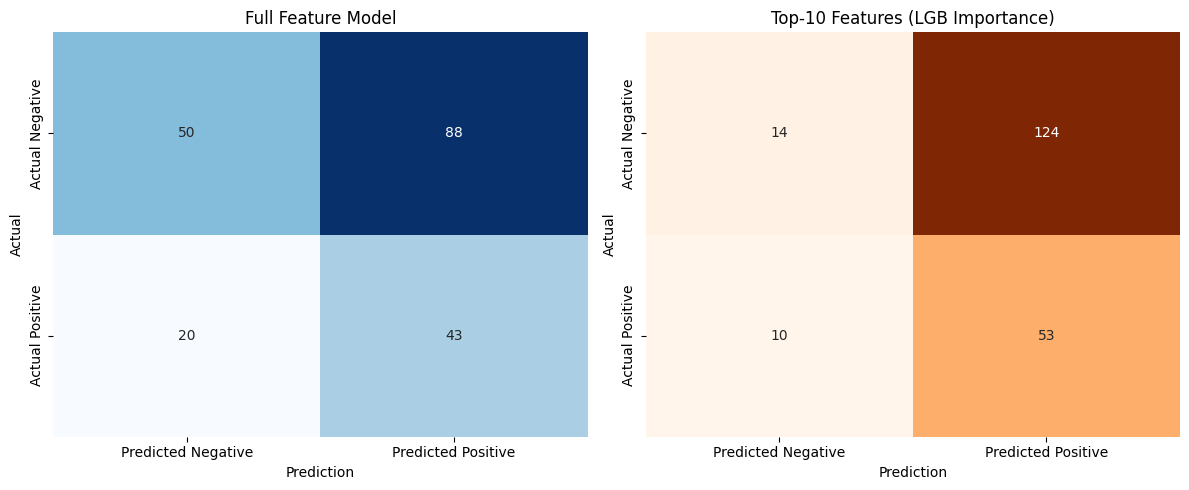

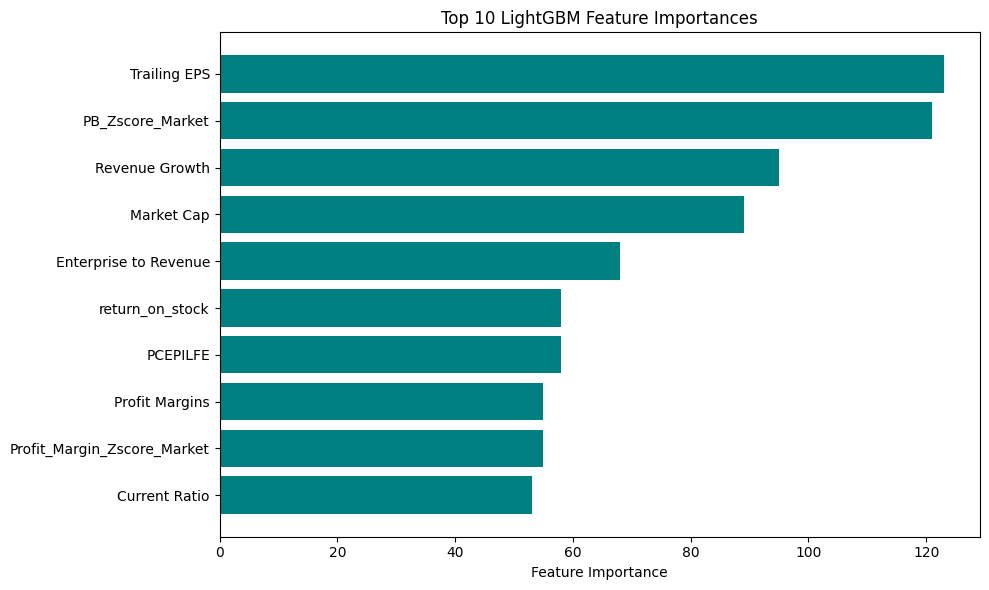

In [ ]:
# === 🚀 Baseline: Logistic Regression Performance ===
baseline_logistic(X_train, y_train, X_val, y_val)

# === 🔍 Step 1: Hyperparameter Tuning with Optuna for LightGBM ===
best_params = tune_lightgbm_with_optuna(df, features)

# === 🌲 Step 2: Train Full Feature Model & Predict 2022–2023 ===
model, y_pred, y_prob = predict_2022_2023(df, features, best_params)

# === 🔧 Step 3: Select Top-N Important Features using LightGBM Importance ===
X_top = select_top_features_lgb(model, X, top_n=10)

# Create a reduced DataFrame with only top features, Y, and year
df_top = df[X_top.columns.tolist() + ['Y', 'year']]

# === 🌱 Step 4: Retrain Model Using Top Features Only ===
model_top, _, _ = predict_2022_2023(df_top, X_top.columns.tolist(), best_params)

# === 📊 Step 5: Compare Full Model vs. Top Feature Model ===
compare_models_lgb_importance(df, features, best_params, top_n=10)


In [ ]:
def predict_2022_2023_and_save(df, features, best_params, model_path="final_model.pkl"):
    # 🔹 Step 1: Split data into train (≤2021) and test (2022–2023)
    df_train = df[df['year'] <= 2021]
    df_test = df[df['year'].isin([2022, 2023])]

    X_train, y_train = df_train[features], df_train['Y']
    X_test, y_test = df_test[features], df_test['Y']

    # 🔹 Step 2: Convert to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test)

    # 🔹 Step 3: Train final model with early stopping and logging
    final_model = lgb.train(
        best_params,
        train_data,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(50),      # Stop if no improvement after 50 rounds
            lgb.log_evaluation(100)      # Print logs every 100 rounds
        ]
    )

    # 🔹 Step 4: Make predictions and evaluate
    y_prob = final_model.predict(X_test)
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    print(f"\n✅ 2022–2023 Prediction → AUC: {auc:.4f}, F1: {f1:.4f}")

    # 🔹 Step 5: Save model to Google Drive
    model_path = "/content/drive/My Drive/final_model.pkl"
    with open(model_path, "wb") as file:
        pickle.dump(final_model, file)

    print(f"✅ Model saved to: {model_path}")
    return final_model, auc, f1


In [ ]:
model, auc, f1 = predict_2022_2023_and_save(df, features, best_params, model_path="final_model.pkl")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 0.254506

✅ 2022–2023 Prediction → AUC: 0.5750, F1: 0.4674
✅ Model saved to: /content/drive/My Drive/final_model.pkl


In [ ]:
#print(X_top)
important_features = X_top.columns.tolist()
print(important_features)

['Trailing EPS', 'PB_Zscore_Market', 'Revenue Growth', 'Market Cap', 'Enterprise to Revenue', 'return_on_stock', 'PCEPILFE', 'Profit Margins', 'Profit_Margin_Zscore_Market', 'Current Ratio']


In [ ]:
X_train = X_train[important_features]
X_val = X_val[important_features]

## baseline_models_comparison
- logistic regression
- SVM
- XGBoost
- lightgbm
- catboost

In [ ]:
def baseline_models_comparison(X_train, X_val, y_train, y_val, best_params, use_catboost=False):
    """
    Compare baseline classifiers: Logistic Regression, SVM, XGBoost, LightGBM, and optionally CatBoost.

    Parameters:
        X_train, X_val: Feature matrices for training and validation.
        y_train, y_val: Labels for training and validation.
        best_params (dict): Best hyperparameters for LightGBM.
        use_catboost (bool): Whether to include CatBoost in the comparison.

    Returns:
        dict: Model evaluation results including model object, F1 score, AUC, and confusion matrix.
    """
    results = {}

    # Logistic Regression with scaling
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', max_iter=1000))
    ])
    lr_pipeline.fit(X_train, y_train)
    y_pred = lr_pipeline.predict(X_val)
    y_prob = lr_pipeline.predict_proba(X_val)[:, 1]
    results['Logistic Regression'] = {
        "model": lr_pipeline,
        "f1": f1_score(y_val, y_pred),
        "auc": roc_auc_score(y_val, y_prob),
        "confusion": confusion_matrix(y_val, y_pred)
    }

    # Support Vector Machine
    svm = SVC(probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    y_prob = svm.predict_proba(X_val)[:, 1]
    results['SVM'] = {
        "model": svm,
        "f1": f1_score(y_val, y_pred),
        "auc": roc_auc_score(y_val, y_prob),
        "confusion": confusion_matrix(y_val, y_pred)
    }

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    y_prob = xgb.predict_proba(X_val)[:, 1]
    results['XGBoost'] = {
        "model": xgb,
        "f1": f1_score(y_val, y_pred),
        "auc": roc_auc_score(y_val, y_prob),
        "confusion": confusion_matrix(y_val, y_pred)
    }

    # LightGBM
    lgbm = lgb.LGBMClassifier(**best_params)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_val)
    y_prob = lgbm.predict_proba(X_val)[:, 1]
    results['LightGBM'] = {
        "model": lgbm,
        "f1": f1_score(y_val, y_pred),
        "auc": roc_auc_score(y_val, y_prob),
        "confusion": confusion_matrix(y_val, y_pred)
    }

    # Optional: CatBoost
    if use_catboost:
        try:
            from catboost import CatBoostClassifier
            cat = CatBoostClassifier(verbose=0)
            cat.fit(X_train, y_train)
            y_pred = cat.predict(X_val)
            y_prob = cat.predict_proba(X_val)[:, 1]
            results['CatBoost'] = {
                "model": cat,
                "f1": f1_score(y_val, y_pred),
                "auc": roc_auc_score(y_val, y_prob),
                "confusion": confusion_matrix(y_val, y_pred)
            }
        except Exception as e:
            print("[⚠️ Warning] CatBoost failed:", str(e))

    print("\n=== Baseline Model Performance ===")
    for name, res in results.items():
        print(f"{name:18s} → F1: {res['f1']:.4f}, AUC: {res['auc']:.4f}")

    return results


In [ ]:
def plot_confusion_matrices(results_dict):
    """
    Plot confusion matrices for multiple models side by side.

    Parameters:
        results_dict (dict): Dictionary containing model evaluation results,
                             each with a 'confusion' matrix.
    """
    models = list(results_dict.keys())
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))

    if len(models) == 1:
        axes = [axes]

    for ax, model_name in zip(axes, models):
        cm = results_dict[model_name]['confusion']
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", ax=ax,
                    cbar=False, xticklabels=True, yticklabels=True,
                    linewidths=0.5, linecolor='gray', square=True)

        max_val = cm.max()
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                color = "white" if cm[i, j] > max_val / 2 else "black"
                ax.text(j + 0.5, i + 0.5, str(cm[i, j]),
                        ha='center', va='center',
                        color=color, fontsize=14, fontweight='bold')

        ax.set_title(model_name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_f1_auc_bar(results_dict):
    """
    Plot a grouped bar chart comparing F1 and AUC scores across models.

    Parameters:
        results_dict (dict): Dictionary containing model evaluation results,
                             each with 'f1' and 'auc' scores.
    """
    models = list(results_dict.keys())
    f1_scores = [results_dict[m]['f1'] for m in models]
    auc_scores = [results_dict[m]['auc'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
    bars2 = ax.bar(x + width/2, auc_scores, width, label='AUC Score')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison (F1 vs AUC)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


In [ ]:
X_train.columns

Index(['Trailing EPS', 'PB_Zscore_Market', 'Revenue Growth', 'Market Cap',
       'Enterprise to Revenue', 'return_on_stock', 'PCEPILFE',
       'Profit Margins', 'Profit_Margin_Zscore_Market', 'Current Ratio'],
      dtype='object')


=== Baseline Model Performance ===
Logistic Regression → F1: 0.4735, AUC: 0.5504
SVM                → F1: 0.4253, AUC: 0.5551
XGBoost            → F1: 0.3929, AUC: 0.3440
LightGBM           → F1: 0.4417, AUC: 0.4441


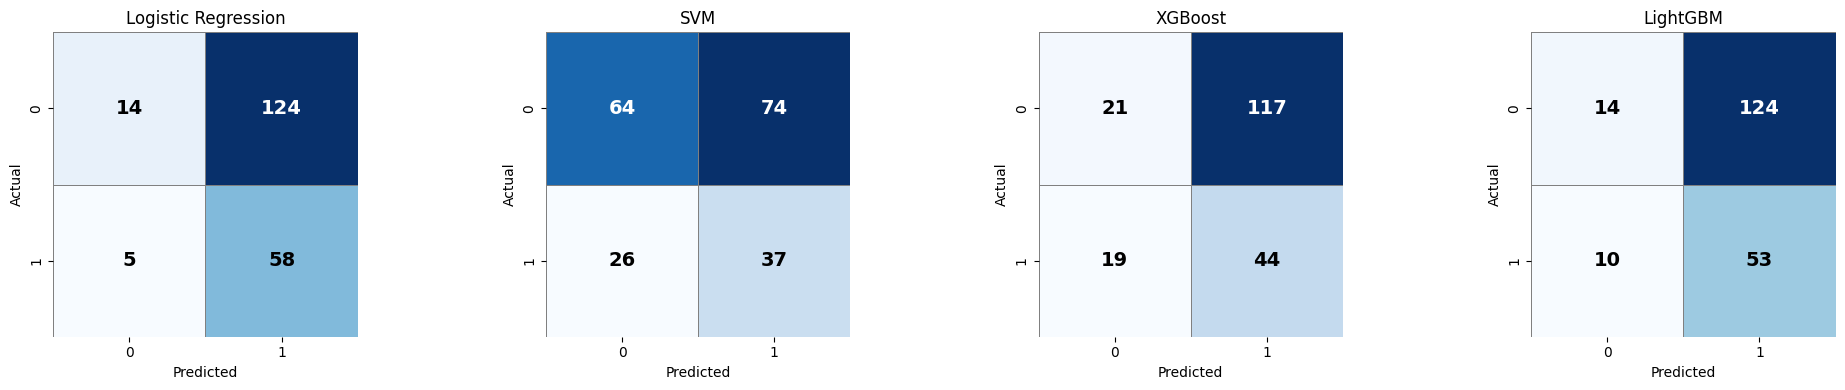

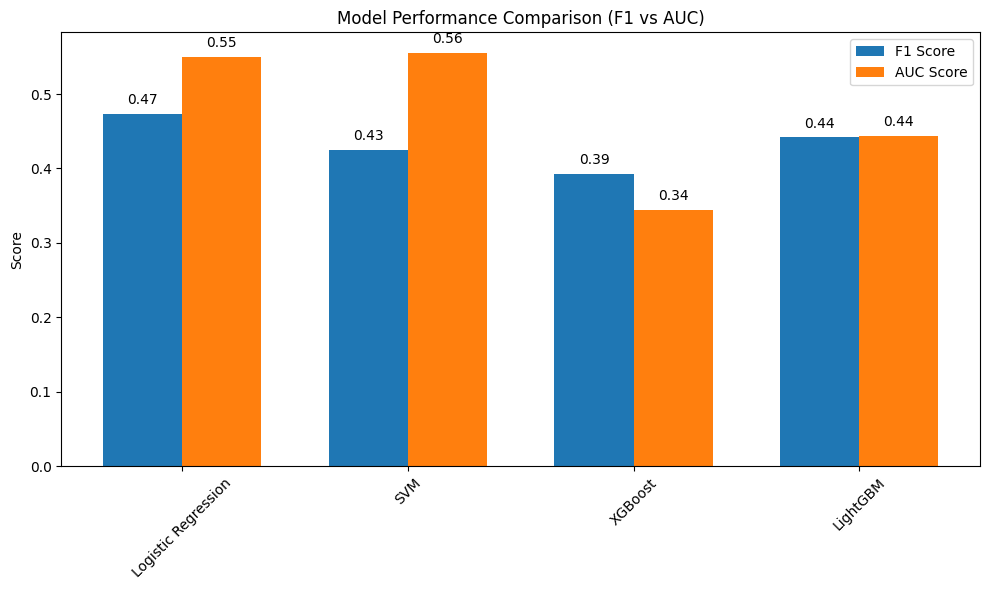

In [ ]:
results = baseline_models_comparison(X_train, X_val, y_train, y_val, best_params)
plot_confusion_matrices(results)
plot_f1_auc_bar(results)

In [ ]:
def fetch_annual_avg(year, indicator):
    """
    Helper function to fetch the annual average of a single FRED indicator.
    If data is unavailable for the given year, fetches the previous year's data.
    """
    start_date = datetime.datetime(year, 1, 1)
    end_date = datetime.datetime(year, 12, 31)

    try:
        data = web.DataReader(indicator, 'fred', start_date, end_date)
        if not data.empty:
            return data.mean().iloc[0]
    except Exception as e:
        print(f"Error fetching data for {indicator} in {year}: {e}")

    # If no data, try previous year
    print(f"No data for {indicator} in {year}, trying {year - 1}")
    return fetch_annual_avg(year - 1, indicator)

def get_fred_annual_avg(year):
    """
    Fetch the annual average of selected FRED macroeconomic indicators for a given year.
    If a value is None, tries fetching data from the previous year.
    """
    indicators = ["DGS10", "PCEPILFE", "INDPRO", "RBUSBIS", "M2SL", "UNRATE", "FEDFUNDS", "USEPUINDXD"]
    results = {}

    for indicator in indicators:
        results[indicator] = fetch_annual_avg(year, indicator)

    # Fetch GDP growth rate
    results["GDP_Growth_Rate"] = fetch_annual_avg(year, "A191RL1Q225SBEA") / 100  # Convert percentage to decimal

    return results

# Example usage:
#print(get_fred_annual_avg(2023))


In [ ]:
def get_last_friday(year):
    """Find the last Friday of December for a given year."""
    last_day = datetime.date(year, 12, 31)

    # If it's not a Friday, move back to the most recent Friday
    while last_day.weekday() != 4:  # 4 = Friday
        last_day -= datetime.timedelta(days=1)

    return last_day.strftime("%Y-%m-%d")

In [ ]:
import yfinance as yf

def get_annual_financial_ratios(ticker, year):
    """
    Retrieve key financial ratios and performance metrics for a given stock and year.

    Parameters:
        ticker (str or list): Ticker symbol(s) of the stock(s).
        year (int): Target fiscal year for extracting financials.

    Returns:
        dict: Dictionary of financial metrics for each ticker.
    """
    if isinstance(ticker, str):
        tickers = [ticker]
    else:
        tickers = ticker

    data = {}

    for t in tickers:
        stock = yf.Ticker(t)

        try:
            financials = stock.financials
            balance_sheet = stock.balance_sheet
            cashflow = stock.cashflow
            info = stock.info

            def get_value(df, row_name, year_offset=0):
                if row_name in df.index:
                    col_values = df.loc[row_name].dropna()
                    if len(col_values) > year_offset:
                        return col_values.iloc[year_offset]
                return None

            latest_year = financials.columns[0].year
            year_offset = latest_year - year

            net_income = get_value(financials, "Net Income", year_offset)
            total_assets = get_value(balance_sheet, "Total Assets", year_offset)
            total_equity = get_value(balance_sheet, "Common Stock Equity", year_offset)
            total_debt = get_value(balance_sheet, "Total Debt", year_offset)
            revenue = get_value(financials, "Total Revenue", year_offset)
            operating_income = get_value(financials, "Operating Income", year_offset)
            current_assets = get_value(balance_sheet, "Current Assets", year_offset)
            current_liabilities = get_value(balance_sheet, "Current Liabilities", year_offset)
            shares_outstanding = get_value(balance_sheet, "Ordinary Shares Number", year_offset)
            total_cash = get_value(balance_sheet, "Cash And Cash Equivalents", year_offset)
            revenue_current = get_value(financials, "Total Revenue", year_offset)
            revenue_previous = get_value(stock.financials.shift(-1), "Total Revenue", year_offset + 1)

            revenue_growth = ((revenue_current - revenue_previous) / revenue_previous) * 100 \
                if revenue_current and revenue_previous else None

            trailing_eps = info.get("trailingEps")

            # Annual stock return
            start_price_data = stock.history(start=f"{year}-01-01", end=f"{year}-01-10")
            end_price_data = stock.history(start=f"{year}-12-20", end=f"{year + 1}-01-05")
            start_price = start_price_data["Close"].iloc[0] if not start_price_data.empty else None
            end_price = end_price_data["Close"].iloc[-1] if not end_price_data.empty else None
            return_on_stock = ((end_price - start_price) / start_price) * 100 if start_price and end_price else None

            # NDX benchmark return
            ndx = yf.Ticker("^NDX")
            ndx_start = ndx.history(start=f"{year}-01-01", end=f"{year}-01-10")
            ndx_end = ndx.history(start=f"{year}-12-20", end=f"{year + 1}-01-05")
            ndx_start_price = ndx_start["Close"].iloc[0] if not ndx_start.empty else None
            ndx_end_price = ndx_end["Close"].iloc[-1] if not ndx_end.empty else None
            ndx_annual_return = ((ndx_end_price - ndx_start_price) / ndx_start_price) * 100 \
                if ndx_start_price and ndx_end_price else None

            last_price = end_price
            market_cap = last_price * shares_outstanding if last_price and shares_outstanding else None

            return_on_assets = (net_income / total_assets) * 100 if net_income and total_assets else None
            return_on_equity = (net_income / total_equity) * 100 if net_income and total_equity else None
            profit_margin = (net_income / revenue) * 100 if net_income and revenue else None
            current_ratio = current_assets / current_liabilities if current_assets and current_liabilities else None
            price_to_book = market_cap / total_equity if market_cap and total_equity else None
            price_to_sales = market_cap / revenue if market_cap and revenue else None
            enterprise_to_revenue = (market_cap + total_debt - total_cash) / revenue \
                if market_cap and total_debt and total_cash and revenue else None
            operating_margin = (operating_income / revenue) * 100 if operating_income and revenue else None

            data[t] = {
                "Price to Book Ratio": price_to_book,
                "Profit Margins": profit_margin,
                "Enterprise to Revenue": enterprise_to_revenue,
                "Market Cap": market_cap,
                "Revenue Growth (%)": revenue_growth,
                "Return on Assets (%)": return_on_assets,
                "Trailing EPS": trailing_eps,
                "Return on Equity (%)": return_on_equity,
                "Current Ratio": current_ratio,
                "Price to Sales Ratio": price_to_sales,
                "Operating Margin (%)": operating_margin,
                "Annual Stock Return (%)": return_on_stock,
                "NDX Annual Return (%)": ndx_annual_return
            }

        except Exception as e:
            data[t] = {"Error": str(e)}

    return data


In [ ]:
X.columns

Index(['return_on_stock', 'NDX_annual_return', 'Price to Book Ratio',
       'Profit Margins', 'Enterprise to Revenue', 'Market Cap',
       'Revenue Growth', 'Return on Assets', 'Trailing EPS',
       'Return on Equity', 'Current Ratio', 'operating margin', 'DGS10',
       'PCEPILFE', 'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE',
       'FEDFUNDS', 'USEPUINDXD', 'Cluster_0', 'Cluster_1', 'Cluster_2',
       'Cluster_3', 'Cluster_4', 'Profit_Margin_Zscore_Market',
       'PB_Zscore_Market', 'year_sin', 'year_cos'],
      dtype='object')

In [ ]:
#feature_order = X.columns.tolist()
feature_order = ['return_on_stock', 'NDX_annual_return', 'Price to Book Ratio',
       'Profit Margins', 'Enterprise to Revenue', 'Market Cap',
       'Revenue Growth', 'Return on Assets', 'Trailing EPS',
       'Return on Equity', 'Current Ratio', 'operating margin', 'DGS10',
       'PCEPILFE', 'INDPRO', 'RBUSBIS', 'M2SL', 'GDP_Growth_Rate', 'UNRATE',
       'FEDFUNDS', 'USEPUINDXD', 'Cluster_0', 'Cluster_1', 'Cluster_2',
       'Cluster_3', 'Cluster_4', 'Profit_Margin_Zscore_Market', 'PB_Zscore_Market', 'year_sin', 'year_cos']

In [ ]:
def data_preprocessing(new_data, historical_data):
    """
    Preprocess new input data for prediction using prior cluster labels and historical statistics.

    Steps:
    - Load existing cluster one-hot labels from CSV (no KMeans re-run).
    - Fill missing financial values using historical market averages (no NMF transform).
    - Encode time features and calculate financial Z-scores.
    - Align feature columns to match training data format.

    Parameters:
        new_data (pd.DataFrame): New observation(s) to preprocess.
        historical_data (pd.DataFrame): Historical panel data used to compute market-level stats.

    Returns:
        pd.DataFrame: Preprocessed feature-aligned data ready for prediction.
    """
    # Step 1: Load existing cluster labels
    cluster_labels = pd.read_csv("/content/drive/My Drive/cluster_labels.csv")

    # Step 2: Ensure ID format consistency
    cluster_labels["ID"] = cluster_labels["ID"].astype(str)
    new_data["ID"] = new_data["ID"].astype(str)

    # Step 3: Merge cluster labels and apply one-hot encoding
    new_data = new_data.merge(cluster_labels, on="ID", how="left")
    df_encoded = pd.get_dummies(new_data, columns=["Cluster"], prefix="Cluster", dtype=int)

    # Ensure Cluster_0 ~ Cluster_4 all exist
    for col in [f"Cluster_{i}" for i in range(5)]:
        if col not in df_encoded.columns:
            df_encoded[col] = 0

    new_data = df_encoded

    # Step 4: Encode year as cyclic features
    new_data["year"] = new_data["year"].astype(int)
    new_data["year_sin"] = np.sin(2 * np.pi * new_data["year"] / 14)
    new_data["year_cos"] = np.cos(2 * np.pi * new_data["year"] / 14)
    historical_data["year"] = historical_data["year"].astype(int)

    # Step 5: Compute past 3 years’ market average and std
    def get_past_3_years_stats(current_year, historical_df):
        past = historical_df[
            (historical_df["year"] >= current_year - 3) &
            (historical_df["year"] < current_year)
        ]
        avg = past[["Profit Margins", "Price to Book Ratio"]].mean()
        std = past[["Profit Margins", "Price to Book Ratio"]].std()
        return avg, std

    current_year = new_data["year"].values[0]
    market_avg, market_std = get_past_3_years_stats(current_year, historical_data)

    # Step 6: Compute market-relative Z-scores
    new_data["Profit_Margin_Zscore_Market"] = (
        (new_data["Profit Margins"] - market_avg["Profit Margins"]) / market_std["Profit Margins"]
    )
    new_data["PB_Zscore_Market"] = (
        (new_data["Price to Book Ratio"] - market_avg["Price to Book Ratio"]) / market_std["Price to Book Ratio"]
    )

    # Step 7: Handle NaNs and infinities in Z-scores
    for col in ["Profit_Margin_Zscore_Market", "PB_Zscore_Market"]:
        new_data[col] = new_data[col].replace([np.inf, -np.inf], 0).fillna(0)

    # # Step 8: Drop unnecessary columns
    # new_data.drop(
    #     columns=["Profit Margins", "Price to Book Ratio", "Price to Sales Ratio", "ID"],
    #     inplace=True,
    #     errors="ignore"
    # )

    # Step 9: Reorder columns to match training set
    new_data = new_data.reindex(columns=feature_order)

    print("🔍 Processed new data shape:", new_data.shape)
    return new_data


In [ ]:
feature_name_map = {
    'return_on_stock': 'Stock Annual Return (%)',
    'NDX_annual_return': 'NASDAQ 100 Annual Return(%)',
    'Price to Book Ratio': 'Price-to-Book Ratio',
    'Profit Margins': 'Net Profit Margin (%)',
    'Enterprise to Revenue': 'Enterprise Value to Revenue',
    'Market Cap': 'Market Capitalization',
    'Revenue Growth': 'Revenue Growth Rate (%)',
    'Return on Assets': 'Return on Assets (%)',
    'Trailing EPS': 'Trailing Earnings per Share',
    'Return on Equity': 'Return on Equity (%)',
    'Current Ratio': 'Current Ratio',
    'operating margin': 'Operating Margin (%)',
    'DGS10': '10-Year Treasury Yield yoy',
    'PCEPILFE': 'Core Personal Consumption Expenditures yoy',
    'INDPRO': 'Industrial Production Index yoy',
    'RBUSBIS': 'Real Exchange Rate yoy',
    'M2SL': 'Money Supply M2 yoy',
    'GDP_Growth_Rate': 'GDP Growth Rate yoy',
    'UNRATE': 'Unemployment Rate yoy',
    'FEDFUNDS': 'Federal Funds Rate yoy',
    'USEPUINDXD': 'Economic Policy Uncertainty Index yoy',
    'Cluster_0': 'Cluster Group 0',
    'Cluster_1': 'Cluster Group 1',
    'Cluster_2': 'Cluster Group 2',
    'Cluster_3': 'Cluster Group 3',
    'Cluster_4': 'Cluster Group 4',
    'year_sin': 'Year (sin encoded)',
    'year_cos': 'Year (cos encoded)'
}


In [ ]:
def predictor(ticker, year):
    """
    Predict whether a company's stock will outperform the market in the given year.
    Uses historical labels if available; otherwise, performs model inference and SHAP-based explanation.

    Parameters:
        ticker (str): Stock ticker symbol.
        year (int): Target prediction year.

    Returns:
        str: A formatted performance report.
    """
    historical_data_path = '/content/drive/My Drive/historical_data.csv'
    historical_data = pd.read_csv(historical_data_path)

    # Use label if available for year - 1
    year_to_check = year - 1
    if 2010 <= year_to_check <= 2023:
        filtered_data = historical_data[
            (historical_data['ID'] == ticker) &
            (historical_data['year'] == year_to_check)
        ]

        if not filtered_data.empty:
            actual_label = filtered_data['Y'].iloc[0]
            result = "Outperformed the market 🚀" if actual_label == 1 else "Underperformed the market 📉"
            report = (
                f"📢 Performance Report\n"
                f"----------------------------\n"
                f"🏢 Company: {ticker}\n"
                f"📅 Year: {year}\n"
                f"📊 Result: {result}\n"
                f"----------------------------\n"
            )
            print(report)
            #return report
        else:
            return "Unable to determine performance (no historical label)."

    # If no historical label, proceed with prediction
    X_fred_dict = get_fred_annual_avg(year - 1)
    X_yfinance_dict = get_annual_financial_ratios(ticker, year - 1)[ticker]
    X_merged_dict = {**X_fred_dict, **X_yfinance_dict, "year": year - 1, "ID": ticker}
    X_new = pd.DataFrame([X_merged_dict])

    # Preprocess
    processed_new_data = data_preprocessing(X_new, historical_data)

    # Load model
    with open("/content/drive/My Drive/final_model.pkl", "rb") as file:
        loaded_model = pickle.load(file)

    # Predict
    predictions = loaded_model.predict(processed_new_data)
    binary_prediction = int(np.round(predictions[0]))

    # SHAP explanation
    explainer = shap.Explainer(loaded_model)
    shap_values = explainer(processed_new_data)
    values = shap_values.values[0]
    features = processed_new_data.columns
    inputs = processed_new_data.iloc[0]

    # Top 3 features
    mean_abs_shap = np.abs(values)
    top_idx = np.argsort(mean_abs_shap)[-3:][::-1]

    explanations = []
    for i in top_idx:
        name = features[i]
        shap_val = values[i]
        input_val = inputs[name]
        full_name = feature_name_map.get(name, name)
        direction = "🟢" if shap_val > 0 else "🔴"
        description = (
            f"{direction} {full_name} = {input_val:.2f}. \n\t"
            f"This value pushed the model’s decision toward "
            f"{'outperformance' if shap_val > 0 else 'underperformance'}, "
            f"contributing a SHAP impact of {abs(shap_val):.4f}."
        )
        explanations.append(description)

    result = "Outperformed the market 🚀" if binary_prediction == 1 else "Underperformed the market 📉"
    report = (
        f"📢 Performance Report\n"
        f"----------------------------\n"
        f"🏢 Company: {ticker}\n"
        f"📅 Year: {year}\n"
        f"📊 Predicted Result: {result}\n"
        f"🔍 Key contributing factors (SHAP):\n"
        f"\t{explanations[0]}\n"
        f"\t{explanations[1]}\n"
        f"\t{explanations[2]}\n"
        f"----------------------------\n"
    )

    print(report)
    #return report


In [ ]:
predictor('META', 2024)

📢 Performance Report
----------------------------
🏢 Company: META
📅 Year: 2024
📊 Result: Outperformed the market 🚀
----------------------------



'📢 Performance Report\n----------------------------\n🏢 Company: META\n📅 Year: 2024\n📊 Result: Outperformed the market 🚀\n----------------------------\n'

In [ ]:
predictor('AAPL', 2025)

🔍 Processed new data shape: (1, 30)
📢 Performance Report
----------------------------
🏢 Company: AAPL
📅 Year: 2025
📊 Predicted Result: Outperformed the market 🚀
🔍 Key contributing factors (SHAP):
	🟢 Industrial Production Index yoy = 102.58. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0406.
	🟢 PB_Zscore_Market = 1.26. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0295.
	🔴 Market Capitalization = 3674780742209.62. 
	This value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0233.
----------------------------



'📢 Performance Report\n----------------------------\n🏢 Company: AAPL\n📅 Year: 2025\n📊 Predicted Result: Outperformed the market 🚀\n🔍 Key contributing factors (SHAP):\n\t🟢 Industrial Production Index yoy = 102.58. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0406.\n\t🟢 PB_Zscore_Market = 1.26. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0295.\n\t🔴 Market Capitalization = 3674780742209.62. \n\tThis value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0233.\n----------------------------\n'

In [ ]:
predictor('NVDA', 2025)

🔍 Processed new data shape: (1, 30)
📢 Performance Report
----------------------------
🏢 Company: NVDA
📅 Year: 2025
📊 Predicted Result: Outperformed the market 🚀
🔍 Key contributing factors (SHAP):
	🔴 Enterprise Value to Revenue = 58.49. 
	This value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0324.
	🟢 Industrial Production Index yoy = 102.58. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0278.
	🟢 PB_Zscore_Market = 1.76. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0195.
----------------------------



'📢 Performance Report\n----------------------------\n🏢 Company: NVDA\n📅 Year: 2025\n📊 Predicted Result: Outperformed the market 🚀\n🔍 Key contributing factors (SHAP):\n\t🔴 Enterprise Value to Revenue = 58.49. \n\tThis value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0324.\n\t🟢 Industrial Production Index yoy = 102.58. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0278.\n\t🟢 PB_Zscore_Market = 1.76. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0195.\n----------------------------\n'

In [ ]:
predictor('GOOG', 2025)

🔍 Processed new data shape: (1, 30)
📢 Performance Report
----------------------------
🏢 Company: GOOG
📅 Year: 2025
📊 Predicted Result: Outperformed the market 🚀
🔍 Key contributing factors (SHAP):
	🟢 Industrial Production Index yoy = 102.58. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0470.
	🔴 Market Capitalization = 2355626849594.12. 
	This value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0271.
	🟢 PB_Zscore_Market = -0.29. 
	This value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0201.
----------------------------



'📢 Performance Report\n----------------------------\n🏢 Company: GOOG\n📅 Year: 2025\n📊 Predicted Result: Outperformed the market 🚀\n🔍 Key contributing factors (SHAP):\n\t🟢 Industrial Production Index yoy = 102.58. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0470.\n\t🔴 Market Capitalization = 2355626849594.12. \n\tThis value pushed the model’s decision toward underperformance, contributing a SHAP impact of 0.0271.\n\t🟢 PB_Zscore_Market = -0.29. \n\tThis value pushed the model’s decision toward outperformance, contributing a SHAP impact of 0.0201.\n----------------------------\n'

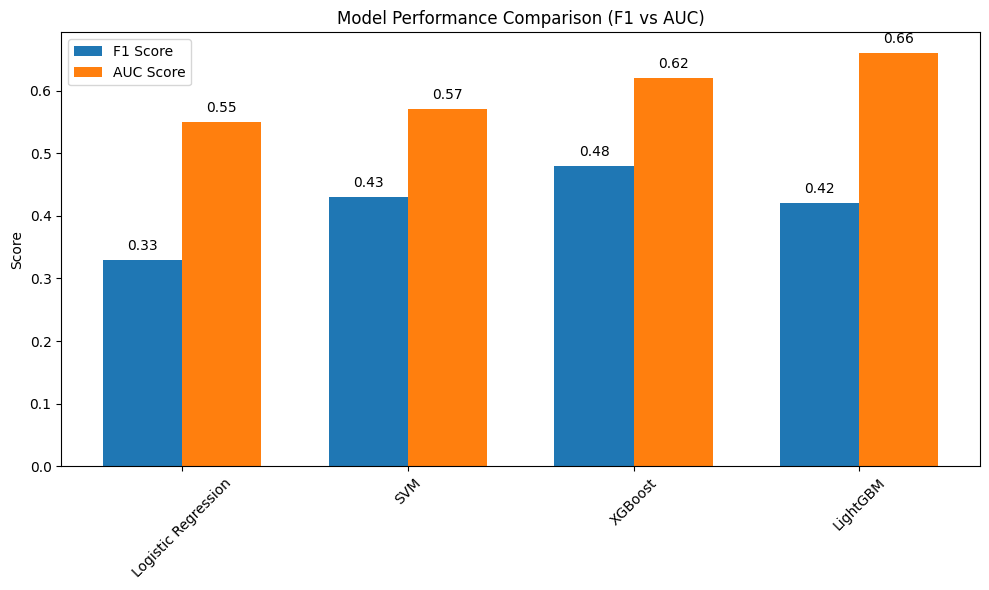

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名稱
models = ["Logistic Regression", "SVM", "XGBoost", "LightGBM"]

# 對應的 F1 和 AUC 值
f1_scores = [0.33, 0.43, 0.48, 0.42]
auc_scores = [0.55, 0.57, 0.62, 0.66]

x = np.arange(len(models))
width = 0.35

# 畫圖
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
bars2 = ax.bar(x + width/2, auc_scores, width, label='AUC Score')

# 標籤與格式
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (F1 vs AUC)')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()

# 在柱子上方標數值
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()
plt.savefig("my_chart.png", transparent=True)

